## Iteration Based Methods - word2vec
Iteration-based methods capture cooccurrence of words one at a time instead of capturing all cooccurence 
counts directly like in SVD method. Word2vec is actually a software package includes 2 algorithms (CBOW, Skip-gram) 
and 2 training methods (negative sampling and hierarchical softmax).  

### continuous bag-of-words (CBOW)
Predicts a center word from the surroudning context in terms of word vectors. V is the input word matrix,
U is the output word matrix. For each word we want to learn both the input and output vectors.  
<br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/CBOW.png?raw=true" width=30% /><br> 
- Generate one hot word vectors for the input context with size **2m**:   
**(x(c-m),...,x(c-1),x(c+1),...,x(c+m) with shape (V, 1))**  
- Get the embedded word vectors for the context: (**n** is the embedded dimension)  
**(v(c-m)=Vx(c-m),v(c-m+1)=Vx(c-m+1),...,v(c+m)=Vx(c+m) with shape (n, 1))**  
- Average all context word vectors, get **v(hat)**.  
- Generate a score vector **z=Uv(hat)(with shape(V, 1))**.  
- Turn the scores into probabilities using **softmax** function.  
- Calculate the cross entropy **H(y(hat), y)** between the predicted probability distribution and 
the one hot vector of the true center word.  
<br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/CBOW_obj.png?raw=true" width=60% /><br> 

In [1]:
import numpy as np
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

import gensim

Using TensorFlow backend.


In [2]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()[:300]
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dim = 100
window_size = 2

In [3]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

In [4]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, activation='softmax'))

In [5]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [6]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow.train_on_batch(x, y)

    print(ite, loss)

0 17897.1324615
1 16611.4819975
2 16054.5737875
3 15975.4586413
4 16078.7989137
5 16168.2691295
6 16193.6849765
7 16191.0186955
8 16183.2132714
9 16174.5272493


In [7]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, dim))

8

In [8]:
vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [9]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [10]:
w2v.most_similar(positive=['the'])

[('a', 0.8029883503913879),
 ('her', 0.6420163512229919),
 ('i', 0.6390146613121033),
 ('it', 0.6209530830383301),
 ('this', 0.6207232475280762),
 ('my', 0.6043308973312378),
 ('you', 0.5718163847923279),
 ('to', 0.5632857084274292),
 ('about', 0.5545670986175537),
 ('down', 0.5478866696357727)]

### Skip-gram (SG)  
Predicts the context words from a center word. V is the input word matrix,
U is the output word matrix. For each word we want to learn both the input and output vectors.  
<br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/SG.png?raw=true" width=30% /><br> 
- Generate one hot word vector for the center word **x, with shape(V, 1)**   
- Get the embedded word vector for the center word: **v(c)=Vx with shape(n, 1)**   
- Generate a score vector **z=Uv(c)(with shape(V, 1))**.  
- Turn the scores into probabilities using **softmax** function.  
- Calculate the cross entropy **H(y(hat), y)** between the predicted probability distribution and 
the one hot vector of the true context words.  
<br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/SG_obj.png?raw=true" width=60% />

### Training methods
- **Negative Sampling**  
For softmax function, the summation over the whole vocabulary(V) is computationally huge. 
A simple idea is to approximate it by sampling the negative samples.  
We can build a new objective function that tries to maximize the probability of a word 
and context being in the corpus data if it indeed is, and maximize the probability of a word 
and context not being in the corpus data if it indeed is not. We take a simple maximum 
likelihood approach of these two probabilities.  
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/NS_01.png?raw=true" width=60% /><br>  
Maximizing the likelihood is the same as minimizing the negative log likelihood. 
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/NS_02.png?raw=true" width=60% /><br>  
We can generate the negative half of cost by randomly sampling this negative from the word bank.
Regarding the sampling function **P(W)**, what seems to work best is the Unigram Model raised to the power of 3/4.  
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/NS_03.png?raw=true" width=30% /><br> 
    - Negative Sampling objective function for **CBOW**  
        <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/NS_CBOW.png?raw=true" width=40% /><br>  
    - Negative Sampling objective function for **Skip-gram**  
        <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/NS_SG.png?raw=true" width=45% />
    
- **Hierarchical Softmax**  
Hierarchical softmax uses a binary tree (like a binary Huffman tree, which assigns frequent
words shorter paths in the tree) to represent all words in the vocabulary.
Each leaf of the tree is a word, and there is a unique path from root to leaf.
In this model, **there is no output representation for words.**
Instead, each node of the graph (except the root and the leaves) is associated to a vector 
that the model is going to learn.  
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/HS.png?raw=true" width=50%/><br>   
Let **L(w)** be the number of nodes in the path from the root to the leaf **w**.
For instance, **L(w2)** in the above figure is 3.
Let’s write **n(w, i)** as the **i-th** node on this path with associated vector **vn(w,i)**.
So **n(w, 1)** is the root, while **n(w, L(w))** is the father of **w**.
Now for each inner node **n**, we arbitrarily choose one of its
children and call it **ch(n)** (e.g. always the left node). Then, we can
compute the probability as  
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/HS_PROB.png?raw=true" width=60%/><br>   
For example, taking w2 in the above figure, we must take two left edges and then a right 
edge to reach w2 from the root, so  
    <br><img src="https://github.com/SauceCat/NLP-Playground/blob/master/word_embedding/images/HS_example.png?raw=true" width=60%/><br>   
To train the model, our goal is still to minimize the negative log likelihood **-log P(w|wi)**.
But instead of updating output vectors per word, we update the vectors of the nodes in the binary 
tree that are in the path from root to leaf node.

In [ ]:
import numpy as np
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer, base_filter
from keras.utils.visualize_util import model_to_dot, plot
from gensim.models.doc2vec import Word2Vec

In [ ]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:200]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dim = 100
window_size = 2

In [ ]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
                    
            in_words = []
            labels = []
            for i in range(s, e):
                if i != index and 0 <= i < L:
                    in_words.append([word] )
                    labels.append(words[i])

            x = np.array(in_words,dtype=np.int32)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

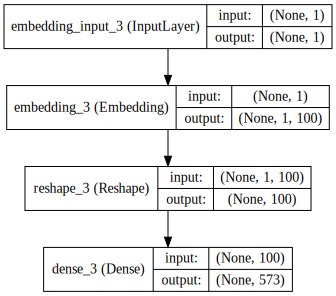

In [ ]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, output_dim=V, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [ ]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += skipgram.train_on_batch(x, y)

    print(ite, loss)

0 10880.5715966
1 10205.9945803
2 10074.3077066
3 9965.59868503
4 9854.57731271
5 9750.60724521
6 9657.09119558
7 9572.85030174
8 9495.95489979
9 9424.25686908


In [ ]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [ ]:
vectors = skipgram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [ ]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['alice'])

[('s', 0.42469197511672974),
 ('too', 0.4138217866420746),
 ('whether', 0.3842674493789673),
 ('wonderland', 0.368587851524353),
 ('in', 0.36720913648605347),
 ('that', 0.3651423156261444),
 ('adventures', 0.3534693419933319),
 ('labelled', 0.31480032205581665),
 ('yes', 0.30488651990890503),
 ('got', 0.29601991176605225)]

## PV-DM

Every paragraph is mapped to a unique vector, represented by a column in matrix **D** and every word is also mapped to a unique vector, represented by a column in matrix **W**. The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context.  

In other words, when predicting the next word given a number of context words, the paragraph vectors are also asked to contribute to the prediction task of the next word given many contexts sampled from the paragraph. **So the major different between this model and CBOW model is, here h is constructed from W and D.**  
<br><center><img src='https://github.com/SauceCat/NLP-Playground/blob/master/doc2vec/images/word2vec.png?raw=true' width=50%></center><br>

The paragraph token can be thought of as another word. It acts as a memory that remembers what is missing from the current context – or the topic of the paragraph. For this reason, this model is named **Distributed Memory Model of Paragraph Vectors (PV-DM)**.  
<br><center><img src='https://github.com/SauceCat/NLP-Playground/blob/master/doc2vec/images/PV_DM.png?raw=true' width=50%></center><br><br>

The contexts are fixed-length and sampled from a sliding window over the paragraph. The paragraph vector is shared across all contexts generated from the same paragraph but not across paragraphs. The word vector matrix W, how-ever, is shared across paragraphs.  

At prediction time, one needs to perform an inference step to compute the paragraph vector for a new paragraph. This is also obtained by gradient descent. In this step, the parameters for the rest of the model, the word vectors W and the softmax weights, are fixed.  

>Paragraph vectors also address some of the key weaknesses of bag-of-words models.
>1. They inherit an important property of the word vectors: the semantics of the words.  
>2. They take into consideration the word order, at least in a small context.  

## PV-DBOW
Another way is to ignore the context words in the input, but force the model to predict words randomly sampled from the paragraph in the output given the Paragraph Vector. This technique is named as **Distributed Bag of Words (PV-DBOW)**, which is similar to the skip-gram model of word2vec.  
<br><center><img src='https://github.com/SauceCat/NLP-Playground/blob/master/doc2vec/images/PV_DBOW.png?raw=true' width=50%></center><br>
  
Compared with the distributed memory model, this model requires to store less data. We only need to store the softmax weights as opposed to both softmax weights and word vectors in the previous model.


## In practice
PV-DM alone usually works well for most tasks (with state-of-art performances), but its combination with PV-DBOW is usually more consistent across many tasks that we try and therefore strongly recommended.